# Predicting prices with Linear Modelling
***

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import statsmodels.api as sm

## Inputs & EDA

In [224]:
symbol = "GOOG"
df = pd.read_csv("~/Dropbox/Dev/Systrading/Data/{}.csv".format(symbol),
                index_col="date", #indexe on Dates
                parse_dates = True, #get time index objects
                dayfirst = True,) #AA/MM/DD or DD/MM/AA (International and European format)
                #usecols=['date','adjClose'], #only use the columns needed
                #na_values=['nan']) #missing values (week-ends for instance) into 'nan' string)

In [225]:
df.head()

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume
date,,,,,,,,,,,,
2014-03-27,558.46,568.00,552.92,568.000,13100,558.46,0,568.00,552.92,568.000,1,13100
2014-03-28,559.99,566.43,558.67,561.200,41100,559.99,0,566.43,558.67,561.200,1,41100
2014-03-31,556.97,567.00,556.93,566.890,10800,556.97,0,567.00,556.93,566.890,1,10800
2014-04-01,567.16,568.45,558.71,558.710,7900,567.16,0,568.45,558.71,558.710,1,7900
2014-04-02,567.00,604.83,562.19,565.106,146700,567.00,0,604.83,562.19,565.106,1,146700


**Plotted stock price (adjusted close) over time**

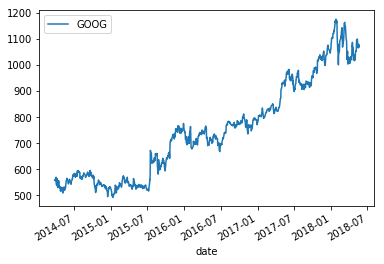

In [226]:
df["adjClose"].plot(label=symbol, legend=True)
plt.show()

**Histogram of the daily percentage returns** (daily price change percent)

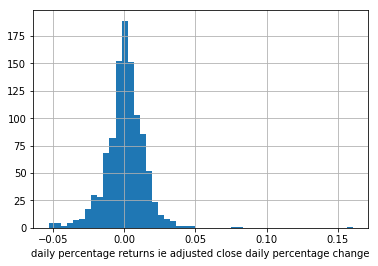

In [227]:
df["adjClose"].pct_change().hist(bins=50)
plt.xlabel("daily percentage returns ie adjusted close daily percentage change")
plt.show()

  
## Autocorrelations 

**Create 5-day % changes of adjClose for the current day and 5 days in the future**

In [228]:
df['5d_future_close'] = df['adjClose'].shift(-5)
df['5d_close_future_pct'] = df['5d_future_close'].pct_change(5)
df['5d_close_pct'] = df['adjClose'].pct_change(5)

**Calculate the correlation matrix between the 5d close pecentage changes (current and future)**

In [229]:
corr = df[['5d_close_pct', '5d_close_future_pct']].corr()
corr

,5d_close_pct,5d_close_future_pct
5d_close_pct,1.000000,-0.129578
5d_close_future_pct,-0.129578,1.000000


**Scatter the current 5-day percent change vs the future 5-day percent change**

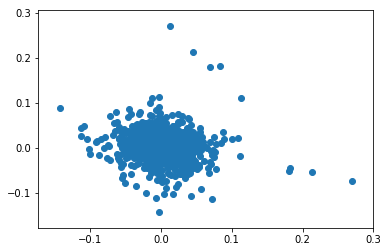

In [230]:
plt.scatter(df['5d_close_pct'], df['5d_close_future_pct'])
plt.show()

## Choosing & creating features

A **moving average** is one of the simplest indicators - it's the average of previous data points. This is the function talib.SMA() from the TAlib library.

Another common technical indicator is the **relative strength index (RSI)**.
This is defined by:
RSI = 100 − 100/(1+RS)
where RS = average gain over n periods / average loss over n periods

The n periods is set in talib.RSI() as the timeperiod argument.
A common period for RSI is 14, so we'll use that as one setting in our calculations.

In [231]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14,30,50,200]:

    # Create the moving average indicator and divide by Adj_Close and add it to the datafrane
    df['ma' + str(n)] = talib.SMA(df['adjClose'].values,
                              timeperiod=n) / df['adjClose']
    # Create the RSI indicator and add it to the datafrane
    df['rsi' + str(n)] = talib.RSI(df['adjClose'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

#### Missing values 

In [232]:
df.head(6)

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,...,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
date,,,,,,,,,,,,,,,,,,,,,
2014-03-27,558.46,568.00,552.92,568.000,13100,558.46,0,568.00,552.92,568.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-28,559.99,566.43,558.67,561.200,41100,559.99,0,566.43,558.67,561.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,556.97,567.00,556.93,566.890,10800,556.97,0,567.00,556.93,566.890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-01,567.16,568.45,558.71,558.710,7900,567.16,0,568.45,558.71,558.710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-02,567.00,604.83,562.19,565.106,146700,567.00,0,604.83,562.19,565.106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-03,569.74,587.28,564.13,569.850,5085200,569.74,0,587.28,564.13,569.850,...,-0.050532,0.020198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our indicators also cause us to have missing values at the beginning of the DataFrame due to the calculations. We could backfill this data, fill it with a single value, or drop the rows. Dropping the rows is a good choice, so our machine learning algorithms aren't confused by any sort of backfilled or 0-filled data. 

In [233]:
df = df.dropna()
df.head(6)

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,...,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
date,,,,,,,,,,,,,,,,,,,,,
2015-01-12,492.55,495.976,487.560,494.94,2320446,492.55,0,495.976,487.560,494.94,...,0.029134,-0.041489,1.049719,30.751389,1.056865,37.363452,1.076069,40.743968,1.121577,47.018047
2015-01-13,496.18,502.980,492.390,498.84,2365687,496.18,0,502.980,492.390,498.84,...,0.044057,-0.011515,1.037910,34.332484,1.046066,38.850271,1.066015,41.572871,1.112729,47.192372
2015-01-14,500.87,503.230,493.000,494.65,2229638,500.87,0,503.230,493.000,494.65,...,0.066924,-0.000459,1.023953,38.740366,1.034079,40.730669,1.053709,42.630880,1.101749,47.417029
2015-01-15,501.79,505.680,497.760,505.57,2711355,501.79,0,505.680,497.760,505.57,...,0.076048,-0.001771,1.018235,39.596888,1.030060,41.098223,1.049647,42.838071,1.099078,47.461094
2015-01-16,508.08,508.190,500.000,500.01,2292043,508.08,0,508.190,500.000,500.01,...,0.053397,0.024004,1.001981,45.234776,1.015784,43.573157,1.034841,44.242919,1.084892,47.761895
2015-01-20,506.90,512.500,506.016,511.00,2225922,506.90,0,512.500,506.016,511.00,...,0.023141,0.029134,1.001012,44.397570,1.016148,43.220720,1.035710,44.035746,1.086797,47.710393


#### Create features and targets using feature_names for features; '5d_close_future_pct' for targets

In [234]:
features = df[feature_names]
targets = df['5d_close_future_pct']
features.head(3)

,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
date,,,,,,,,,
2015-01-12,-0.041489,1.049719,30.751389,1.056865,37.363452,1.076069,40.743968,1.121577,47.018047
2015-01-13,-0.011515,1.037910,34.332484,1.046066,38.850271,1.066015,41.572871,1.112729,47.192372
2015-01-14,-0.000459,1.023953,38.740366,1.034079,40.730669,1.053709,42.630880,1.101749,47.417029


#### Create DataFrame from target column and feature columns

In [235]:
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = df[feature_and_target_cols]
feat_targ_df.head(3)

,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
date,,,,,,,,,,
2015-01-12,0.029134,-0.041489,1.049719,30.751389,1.056865,37.363452,1.076069,40.743968,1.121577,47.018047
2015-01-13,0.044057,-0.011515,1.037910,34.332484,1.046066,38.850271,1.066015,41.572871,1.112729,47.192372
2015-01-14,0.066924,-0.000459,1.023953,38.740366,1.034079,40.730669,1.053709,42.630880,1.101749,47.417029


## Assessing features by looking at correlations 

**Calculate the correlation matrix between features and target**

In [236]:
corr = feat_targ_df.corr()
corr

,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
5d_close_future_pct,1.000000,-0.134631,0.200601,-0.172299,0.185794,-0.200828,0.203982,-0.214003,0.215027,-0.197840
5d_close_pct,-0.134631,1.000000,-0.848477,0.630072,-0.652924,0.493897,-0.522413,0.411750,-0.279822,0.207400
ma14,0.200601,-0.848477,1.000000,-0.808962,0.861014,-0.671567,0.711271,-0.573277,0.389888,-0.300905
rsi14,-0.172299,0.630072,-0.808962,1.000000,-0.911956,0.940224,-0.880997,0.856252,-0.572411,0.556030
ma30,0.185794,-0.652924,0.861014,-0.911956,1.000000,-0.851735,0.922291,-0.762983,0.538618,-0.419196
rsi30,-0.200828,0.493897,-0.671567,0.940224,-0.851735,1.000000,-0.917605,0.975030,-0.719458,0.700998
ma50,0.203982,-0.522413,0.711271,-0.880997,0.922291,-0.917605,1.000000,-0.868709,0.665418,-0.520556
rsi50,-0.214003,0.411750,-0.573277,0.856252,-0.762983,0.975030,-0.868709,1.000000,-0.819893,0.809658
ma200,0.215027,-0.279822,0.389888,-0.572411,0.538618,-0.719458,0.665418,-0.819893,1.000000,-0.825402
rsi200,-0.197840,0.207400,-0.300905,0.556030,-0.419196,0.700998,-0.520556,0.809658,-0.825402,1.000000


**Plot heatmap of correlation matrix**

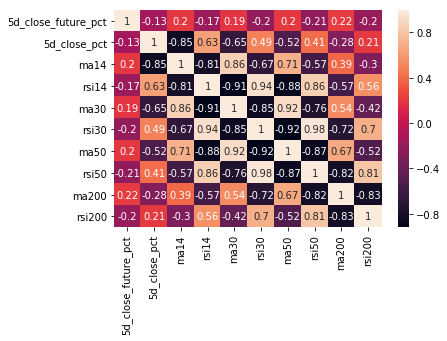

In [237]:
sns.heatmap(corr, annot=True)
plt.show()

**Create a scatter plot of the most highly correlated variable with the target**

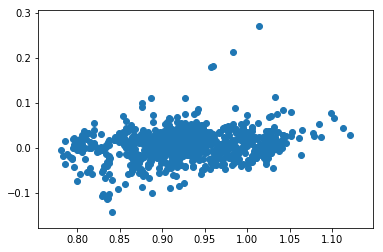

In [238]:
plt.scatter(df['ma200'], df['5d_close_future_pct'])
plt.show()

## Linear modelling 

**Add a constant to the features so we have an intercept for our linear model**

In [239]:
linear_features = sm.add_constant(features)
linear_features.head()

,const,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
date,,,,,,,,,,
2015-01-12,1.0,-0.041489,1.049719,30.751389,1.056865,37.363452,1.076069,40.743968,1.121577,47.018047
2015-01-13,1.0,-0.011515,1.037910,34.332484,1.046066,38.850271,1.066015,41.572871,1.112729,47.192372
2015-01-14,1.0,-0.000459,1.023953,38.740366,1.034079,40.730669,1.053709,42.630880,1.101749,47.417029
2015-01-15,1.0,-0.001771,1.018235,39.596888,1.030060,41.098223,1.049647,42.838071,1.099078,47.461094
2015-01-16,1.0,0.024004,1.001981,45.234776,1.015784,43.573157,1.034841,44.242919,1.084892,47.761895


**Train-test split for time-series data** by **manually** creating a size for the training set that is 85% of the total number of samples

In [240]:
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(842, 10) (715, 10) (127, 10)


**Fit a linear model**

In [241]:
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     5d_close_future_pct   R-squared:                       0.089
Model:                             OLS   Adj. R-squared:                  0.077
Method:                  Least Squares   F-statistic:                     7.630
Date:                 Mon, 20 May 2019   Prob (F-statistic):           9.84e-11
Time:                         19:00:47   Log-Likelihood:                 1465.6
No. Observations:                  715   AIC:                            -2911.
Df Residuals:                      705   BIC:                            -2866.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5197      0.146     -3.567      0.000      -0.806      -0.234
5d_close_pct     0.1185      0.071      1.676      0.094      -0.020       0.257
ma14             0.7713      0.150      5.141      0.000       0.477       1.066
rsi14            0.0017      0.001      1.778      0.076      -0.000       0.004
ma30            -0.5029      0.147     -3.432      0.001      -0.791      -0.215
rsi30           -0.0039      0.004     -0.950      0.342      -0.012       0.004
ma50             0.3122      0.123      2.532      0.012       0.070       0.554
rsi50            0.0036      0.005      0.801      0.423      -0.005       0.012
ma200            0.0195      0.056      0.346      0.730      -0.091       0.130
rsi200          -0.0028      0.002     -1.718      0.086      -0.006       0.000
==============================================================================
Omnibus:                      308.502   Durbin-Watson:                   0.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3910.094
Skew:                           1.581   Prob(JB):                         0.00
Kurtosis:                      14.011   Cond. No.                     2.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Examine pvalues** 
(pvalue is the probability that the null-hypothesis is true, a pvalue <= 0.05 show there is strong relationship/correlation between feature and target)

In [242]:
results.pvalues

const           3.854735e-04
5d_close_pct    9.409459e-02
ma14            3.543448e-07
rsi14           7.585366e-02
ma30            6.338706e-04
rsi30           3.422761e-01
ma50            1.156307e-02
rsi50           4.232319e-01
ma200           7.296119e-01
rsi200          8.620733e-02
dtype: float64

**Make predictions from our model for train and test sets**

In [243]:
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

## Evaluate results 

**Scatter predictions vs actuals values on train set**

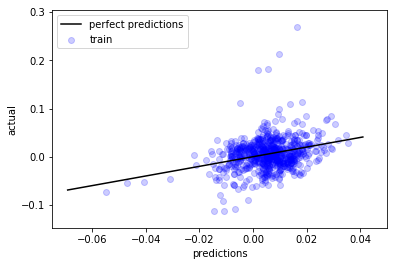

In [248]:
# Scatter the predictions vs the targets on the train data (with 80% transparency)
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect predictions')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

**Scatter predictions vs actuals values on test set**

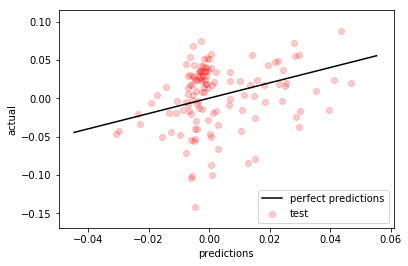

In [254]:
# Scatter the predictions vs the targets on the test data (with 80% transparency)
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect predictions')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend(loc='lower right')
plt.show()